## *Jeu de données IRVE*
-------------------
# Indicateurs d'intégrité des données IRVE
     
### Présentation
Ce document identifie les points de recharge du jeu de données IRVE présentant des problèmes d'intégrité (*ex. une station associée à plusieurs coordonnées différentes, une coordonnée associée à plusieurs adresses*).   
    
Il complète l'analyse des données présentée dans [une note spécifique](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_v3.ipynb).
     
### Sommaire
*(liens actifs sur jupyter Notebook ou [Nbviewer](http://nbviewer.org/github/loco-philippe/Environmental-Sensing/tree/main/python/Validation/irve/Analyse/IRVE_indicateurs.ipynb))*
- [Evolution des données (hors doublons)](#Evolution-des-données-(hors-doublons))
- [Défaut d'intégrité](#Défaut-d\'intégrité)
- [Localisation des stations comportant un écart](#Localisation-des-stations-comportant-un-écart)
- [Annexe - Fonctions utilisées](#Annexe---Fonctions-utilisées)


In [64]:
indic = indicateurs()

## Evolution des données (hors doublons)

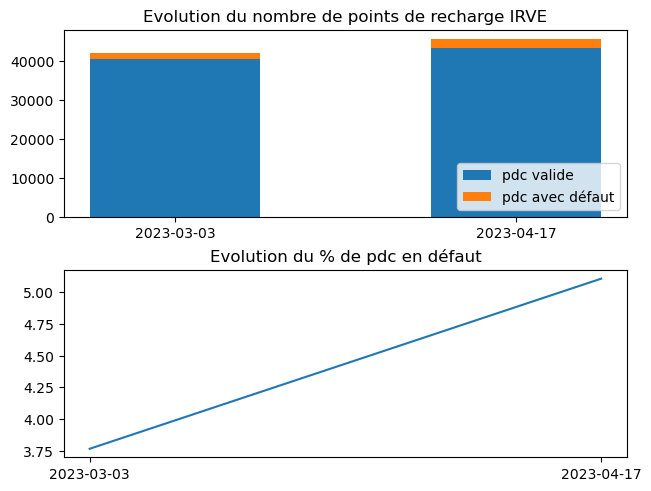

In [65]:
evolution(indic)

## Défaut d'intégrité

{'Station multi-operateurs': 2, 'Station multi-enseignes': 267, 'Station multi-localisations': 537, 'station avec plusieurs noms': 339, 'station multi-implantations': 88, 'nombre de pdc par station incoherent': 842, 'station multi-acces': 8, 'station multi-horaires': 81, 'acces deux-roues incoherent': 448, 'localisation multi-adresses': 414}


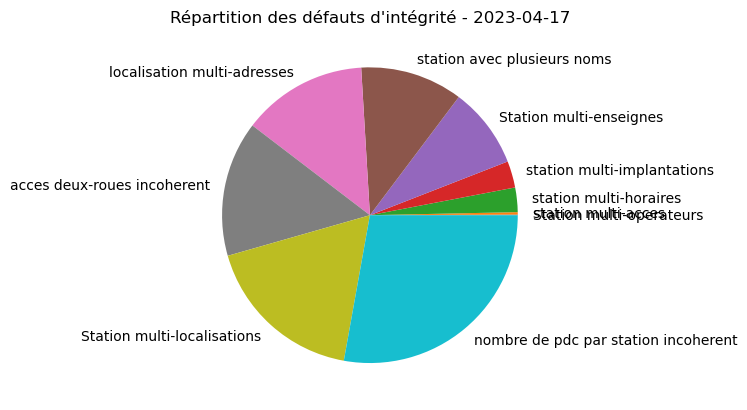

In [66]:
date = defaut_integrite(indic)

## Localisation des stations comportant un écart

In [67]:
defaut_carte(date).show('irve.html')

## Annexe - Fonctions utilisées

In [68]:
def indicateurs():
    log = []
    with open('logfile.txt', 'r', encoding="utf-8") as f:
        for line in f:
            log.append(json.loads(line))
    return log

In [69]:
import matplotlib.pyplot as plt

def defaut_integrite(indic):
    val = dict(item for ind, item in enumerate(indic[len(indic)-1].items()) if 22 < ind < 35 and item[1] > 0)
    print(val)
    val = dict(sorted(val.items(), key=lambda item:item[1], reverse=False))
    date = indic[len(indic)-1]['date_irve']
    
    fig, ax = plt.subplots()
    ax.pie(list(val.values()), labels=list(val.keys()))
    ax.set_title("Répartition des défauts d'intégrité - " + date)
    plt.show()
    return date

In [70]:
def evolution(log):
    dic = {}
    for i, indic in enumerate(log):
        if i == 0:
            dic['date'] = []
            dic['pdc defaut'] = []
            dic['pdc valide'] = []
            dic['pdc default %'] = []
        else:
            date = indic['date_irve']
            dic['date'].append(date)
            dic['pdc defaut'].append(indic['IRVE_itinerance_residuel' + date + '.csv'])
            dic['pdc valide'].append(indic['IRVE_itinerance_valide'   + date + '.csv'])
            dic['pdc default %'].append(100 * dic['pdc defaut'][-1] / (dic['pdc defaut'][-1] + dic['pdc valide'][-1]))

    width = 0.5

    fig, (ax2, ax1) = plt.subplots(2, 1, layout='constrained')
    ax1.plot(dic['date'], dic['pdc default %'])
    ax1.set_title('Evolution du % de pdc en défaut')

    bottom = [0] * (len(log) - 1)
    p = ax2.bar(dic['date'], dic['pdc valide'], width, label='pdc valide', bottom=[0] * (len(log) - 1))
    p = ax2.bar(dic['date'], dic['pdc defaut'], width, label='pdc avec défaut', bottom=dic['pdc valide'])
    ax2.set_title("Evolution du nombre de points de recharge IRVE")
    ax2.legend(loc="lower right")

    plt.show()

In [71]:
from util_carto import Cart

def defaut_carte(date):
    import pandas as pd
    #date = '2023-03-03'
    file = 'IRVE_itinerance_residuel'+date+'.csv'
    #chemin = 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/'
    chemin = 'D:\\philippe\\python ESstandard\\Environmental-Sensing\\python\\Validation\\irve\\Analyse\\'
    #log = {'date_irve': '2022-06-06', 'file': 'consolidation-etalab-schema-irve-v-2.0.2-20220606-propre2.csv',
    #      'chemin': 'D:\\philippe\\python ESstandard\\Environmental-Sensing\\python\\Validation\\irve\\'}
    irve = pd.read_csv(chemin + file, sep=',', low_memory=False)
    
    principal = [17, 18, 19, 20, 21]
    irve['principal'] = True
    for ind in principal:
        irve['principal'] &= irve.iloc[:,ind]
    irve_p = irve[~irve['principal']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    secondaire = [22, 23, 24, 25, 26, 27, 28]
    irve['secondaire'] = True
    for ind in secondaire:
        irve['secondaire'] &= irve.iloc[:,ind]
    irve['secondaire'] |= (~irve['principal'] & ~irve['secondaire'])
    irve_s = irve[~irve['secondaire']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    
    popup = [[], []]
    locat = [[], []]
    for ind, irve in enumerate((irve_p, irve_s)):
        for i in range(len(irve)):
            popup[ind].append( {'id_station': irve['id_station_itinerance'][i], 
                               'id_pdc': irve['id_pdc_itinerance'][i],
                               'contact_operateur': irve['contact_operateur'][i],
                               'nom_enseigne': irve['nom_enseigne'][i],
                               'nom_station': irve['nom_station'][i],
                               'adresse_station': irve['adresse_station'][i],
                               'fichier des écarts': '<a href="https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/">IRVE_itinerance_residuel</a>',
                               'date du fichier': date} )
            coord = json.loads(irve['coordonneesXY'][i])
            coord.reverse()
            locat[ind].append(coord)

    cart = Cart([47, 2.5], zoom_start=6)
    cart.add_markers(locat[0], popup=popup[0], color='red', group='écarts entités', max_width=250)
    cart.add_markers(locat[1], popup=popup[1], color='orange', group='écarts attributs', max_width=250, icon='bug')
    return cart